In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


##Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import os

In [ ]:
csv_path = '/content/drive/MyDrive/TensorFlow/Projects/Skin Disease Classifier/skin-disease-dataset/HAM10000_metadata.csv'

# Load the CSV
df = pd.read_csv(csv_path)

# Preview the data
df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


#Explore Data

In [ ]:
df["dx"].value_counts()

,count
dx,
nv,6705
mel,1113
bkl,1099
bcc,514
akiec,327
vasc,142
df,115


In [ ]:
class_names = df["dx"].unique()
class_names

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [ ]:
#Change diagnosis codes to actual names using a label map

label_map = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

df['dx_name'] = df['dx'].map(label_map)

In [ ]:
df[['image_id', 'dx', 'dx_name']].head()


,image_id,dx,dx_name
0,ISIC_0027419,bkl,Benign keratosis
1,ISIC_0025030,bkl,Benign keratosis
2,ISIC_0026769,bkl,Benign keratosis
3,ISIC_0025661,bkl,Benign keratosis
4,ISIC_0031633,bkl,Benign keratosis


Error: Could not read image at /content/drive/MyDrive/TensorFlow/Projects/Skin Disease Classifier/skin-disease-dataset/HAM10000_images_part_1/ISIC_0031505.jpg
Error: Could not read image at /content/drive/MyDrive/TensorFlow/Projects/Skin Disease Classifier/skin-disease-dataset/HAM10000_images_part_1/ISIC_0029745.jpg
Error: Could not read image at /content/drive/MyDrive/TensorFlow/Projects/Skin Disease Classifier/skin-disease-dataset/HAM10000_images_part_1/ISIC_0032681.jpg


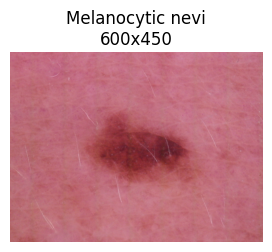

In [ ]:
# prompt: Make a function to look at random images from the data so make it 4 random images at a time and have the name of the disease + the size of each image

import random
import matplotlib.pyplot as plt
import cv2

def display_random_images(df, image_dir, num_images=4):
    """Displays random images from the dataset along with their labels and sizes.

    Args:
        df: Pandas DataFrame containing image metadata.
        image_dir: Path to the directory containing the images.
        num_images: Number of random images to display.
    """

    random_indices = random.sample(range(len(df)), num_images)

    plt.figure(figsize=(15, 5))

    for i, index in enumerate(random_indices):
        image_id = df['image_id'].iloc[index]
        image_path = os.path.join(image_dir, f"{image_id}.jpg")
        dx_name = df['dx_name'].iloc[index]

        try:  # Handle potential errors like missing images
            img = cv2.imread(image_path)
            if img is None:
                print(f"Error: Could not read image at {image_path}")
                continue

            img_height, img_width, _ = img.shape
            plt.subplot(1, num_images, i + 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
            plt.title(f"{dx_name}\n{img_width}x{img_height}")
            plt.axis('off')
        except Exception as e:
            print(f"Error processing image {image_id}: {e}")

    plt.show()

# Example usage (replace with your actual image directory):
image_directory = '/content/drive/MyDrive/TensorFlow/Projects/Skin Disease Classifier/skin-disease-dataset/HAM10000_images_part_1'
display_random_images(df, image_directory)


#Preprocess the data

##Get the image paths

In [ ]:
#Name the 2 folders that contain the images
folder_1 = '/content/drive/MyDrive/TensorFlow/Projects/Skin Disease Classifier/skin-disease-dataset/HAM10000_images_part_1'
folder_2 = '/content/drive/MyDrive/TensorFlow/Projects/Skin Disease Classifier/skin-disease-dataset/HAM10000_images_part_2'

In [ ]:
#Create function to match the images to their paths

import os

def find_image_path(image_id):
    image_name = image_id + '.jpg'
    path1 = os.path.join(folder_1, image_name)
    if os.path.exists(path1):
        return path1
    else:
        return os.path.join(folder_2, image_name)


In [ ]:
#Apply the function to the dataset to create a column of the image paths
df['image_path'] = df['image_id'].apply(find_image_path)

In [ ]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dx_name,image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis,/content/drive/MyDrive/TensorFlow/Projects/Ski...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis,/content/drive/MyDrive/TensorFlow/Projects/Ski...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis,/content/drive/MyDrive/TensorFlow/Projects/Ski...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis,/content/drive/MyDrive/TensorFlow/Projects/Ski...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis,/content/drive/MyDrive/TensorFlow/Projects/Ski...


##Encode the labels

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create the encoder
le = LabelEncoder()

# Fit on the 'dx' column and transform into integers
df['label_encoded'] = le.fit_transform(df['dx'])


In [ ]:
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'akiec': np.int64(0), 'bcc': np.int64(1), 'bkl': np.int64(2), 'df': np.int64(3), 'mel': np.int64(4), 'nv': np.int64(5), 'vasc': np.int64(6)}


##Split the data into training and test sets

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df[["label_encoded","image_path"]],stratify=df["label_encoded"], test_size=0.2, random_state=42)



In [ ]:
#Taking smaller samples of the train and test datasets in order for testing to be fast

train_data_sample = train_data.sample(frac=0.1, random_state=42)
test_data_sample = test_data.sample(frac=0.1, random_state=42)

##Prepare the images to be used as tensors

In [ ]:
#Set some variables

IMG_SIZE = 224
BATCH_SIZE = 32

In [ ]:
#Create function for loading and preprocessing the images

def load_and_preprocess_image(image_path,label):
    image = tf.io.read_file(image_path) # Read the image file
    image = tf.image.decode_jpeg(image, channels=3) # Make sure there are 3 color channels RGB
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) # Resize the image to (224,224)
    image = image/255.0 # Dividing pixel values by 255 in order to normalize them
    return image,tf.cast(label,tf.int32) # Cast label to int32

In [ ]:
#Create tensorflow dataset

train_paths = train_data_sample['image_path'].values
train_labels = train_data_sample['label_encoded'].values

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    train_ds
    .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    .shuffle(buffer_size=1000)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(AUTOTUNE)
)


In [ ]:
test_paths = test_data_sample["image_path"].values
test_labels = test_data_sample["label_encoded"].values

test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

In [ ]:
#Use the same steps as for the training dataset without shuffling
test_ds = (
    test_ds
    .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

#Creating and testing CNN models

##Functions for showing loss and accuracy

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(history):
  loss=history.history["loss"]
  accuracy = history.history["accuracy"]
  val_loss = history.history["val_loss"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.figure()
  plt.plot(epochs,loss,label="Training_loss")
  plt.plot(epochs,val_loss,label="Validation_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs,accuracy,label="Training_accuracy")
  plt.plot(epochs,val_accuracy,label="Validation_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(model, dataset, class_names):
    """
    Plots a confusion matrix for a given model and dataset.

    Parameters:
        model (tf.keras.Model): Your trained model
        dataset (tf.data.Dataset): The validation/test dataset (batched)
        class_names (list): List of class names in order of label indices
    """

    # Step 1: Get true labels and predicted labels
    y_true = []
    y_pred = []

    for images, labels in dataset:
        preds = model.predict(images)
        preds = tf.argmax(preds, axis=1)  # Convert softmax probabilities to class indices
        y_true.extend(labels.numpy())
        y_pred.extend(preds.numpy())

    # Step 2: Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Step 3: Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Step 4: Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))


##Model 1: Simple CNN

In [ ]:
from tensorflow.keras.layers import Dense,Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

#A model with 2 Conv2D layers and 2 MaxPooling2D layers
tf.random.set_seed(42) #Set seed

model_1 = Sequential([ #Define the model
    Input(shape=(224, 224, 3)),
    Conv2D(32, 3, activation="relu",padding="same"),
    MaxPooling2D(),
    Conv2D(32, 3, activation="relu",padding="same"),
    MaxPooling2D(),
    Flatten(),
    Dense(7, activation="softmax")
])

model_1.compile(loss="sparse_categorical_crossentropy", #Compile the model
                optimizer=Adam(),
                metrics=["accuracy"])

history_1 = model_1.fit(train_ds,
                        epochs=3,
                        steps_per_epoch=len(train_data_sample)//BATCH_SIZE,
                        validation_data=test_ds
                                              )

Epoch 1/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.4608 - loss: 2.3970 - val_accuracy: 0.6750 - val_loss: 1.1971
Epoch 2/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 261ms/step - accuracy: 0.6731 - loss: 1.0379 - val_accuracy: 0.6800 - val_loss: 1.0663
Epoch 3/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 431ms/step - accuracy: 0.6837 - loss: 0.9678 - val_accuracy: 0.6750 - val_loss: 1.0291


###Evaluating the model

In [ ]:
model_1.evaluate(test_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.6555 - loss: 1.0689


[1.0290642976760864, 0.675000011920929]

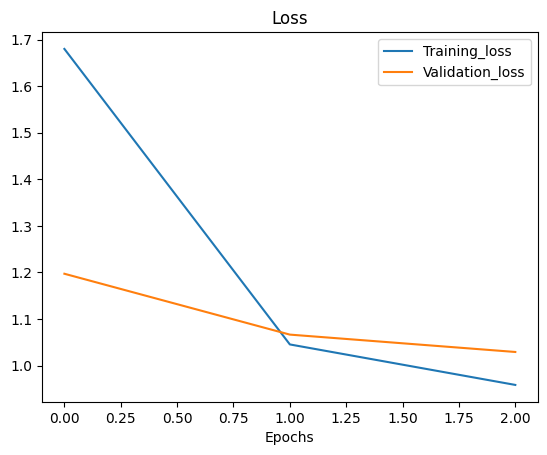

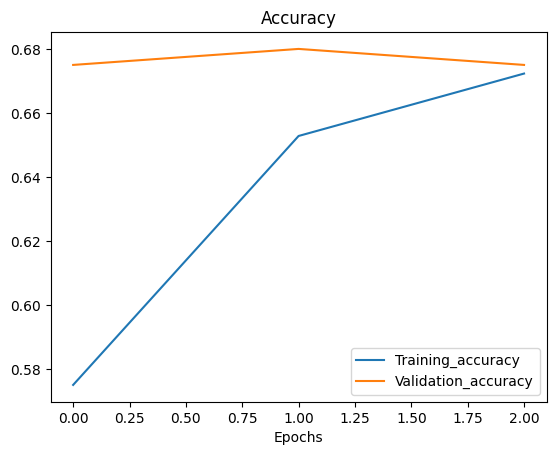

In [ ]:
plot_loss_accuracy(history_1)

In [ ]:
# Model 1 Summary:
# ----------------
# A simple CNN with two Conv2D + MaxPooling2D layers.
# While training loss decreased, validation accuracy stayed flat around ~66%.
# This suggests the model may not have enough capacity to learn complex patterns,
# or it may be underfitting due to its simplicity.
#
#   What we’ll try next:
# - Add more Conv layers to learn deeper features
# - Introduce Dropout to prevent overfitting
# - Use GlobalAveragePooling instead of Flatten to stabilize learning
# - Possibly tune the learning rate


##Model 2: Deeper CNN

In [ ]:
from tensorflow.keras.layers import Dense,Conv2D, MaxPooling2D, Flatten, Input, Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

#A model with 3 increasingly deeper Conv2D layers and 3 MaxPooling2D layers with a GlobalAveragePooling2D layer and an extra dense layer
tf.random.set_seed(42)

model_2 = Sequential([
    Input(shape=(224, 224, 3)),

    Conv2D(32, 3, activation="relu",padding="same"),
    MaxPooling2D(),

    Conv2D(64, 3, activation="relu",padding="same"),
    MaxPooling2D(),

    Dropout(0.3),

    Conv2D(128, 3, activation="relu",padding="same"),
    MaxPooling2D(),

    GlobalAveragePooling2D(),
    Dense(128, activation="relu"), # Intermediate dense layer
    Dropout(0.5),
    Dense(7, activation="softmax")
])

model_2.compile(loss="sparse_categorical_crossentropy",
                optimizer=Adam(learning_rate=0.0001), # Lower learning rate than default due to deeper layers
                metrics=["accuracy"])

history_2 = model_2.fit(train_ds,
                        steps_per_epoch=len(train_data_sample)//BATCH_SIZE,
                        epochs=3,
                        validation_data=test_ds,
                        )


Epoch 1/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 199ms/step - accuracy: 0.1303 - loss: 1.9967 - val_accuracy: 0.6750 - val_loss: 1.7687
Epoch 2/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.6459 - loss: 1.6137 - val_accuracy: 0.6750 - val_loss: 1.3545
Epoch 3/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 397ms/step - accuracy: 0.6597 - loss: 1.3400 - val_accuracy: 0.6750 - val_loss: 1.1800


###Evaluating the model

In [ ]:
model_2.evaluate(test_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.6555 - loss: 1.2110


[1.179984211921692, 0.675000011920929]

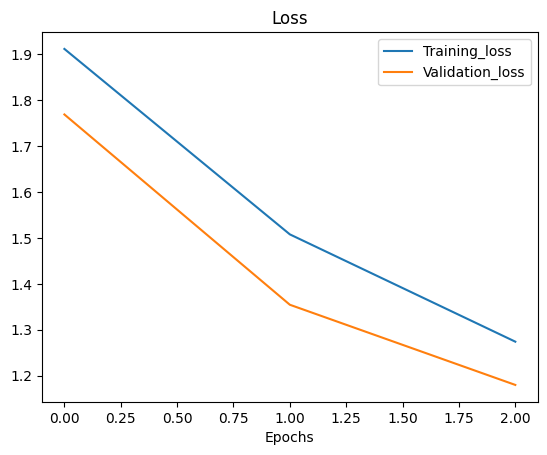

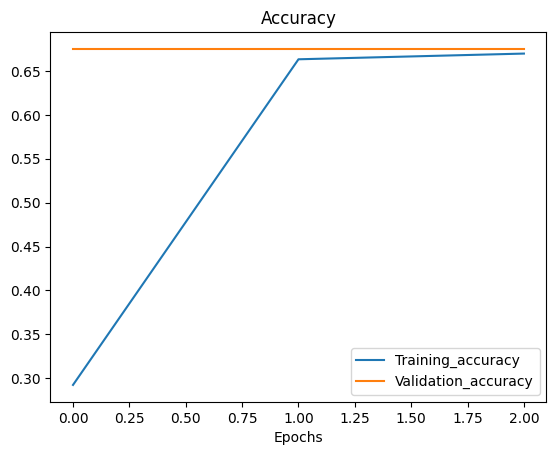

In [ ]:
plot_loss_accuracy(history_2)

## 🛠 Fixing Data Imbalance with Stratified Sampling

After testing Model 1 and Model 2, validation accuracy was stuck around ~68%, and training accuracy kept improving.  
This hinted at a **data imbalance problem** — the training sample likely overrepresented the most common class (`nv`), which biased the model.

To fix this, I used **stratified sampling** to keep all classes equally represented in the training set.



###Make the stratified dataset

In [ ]:
# Stratified sampling to fix class imbalance in training sample
train_data_strat = (
    train_data
    .groupby("label_encoded", group_keys=False)
    .apply(lambda x: x.sample(frac=0.4, random_state=42))
    .reset_index(drop=True)
)

# Check the new class balance
train_data_strat['label_encoded'].value_counts()


<ipython-input-33-a488aec76db8>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=0.4, random_state=42))


,count
label_encoded,
5,2146
4,356
2,352
1,164
0,105
6,46
3,37


In [ ]:
train_paths = train_data_strat['image_path'].values
train_labels = train_data_strat['label_encoded'].values

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = (
    train_ds
    .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    .shuffle(buffer_size=1000)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(AUTOTUNE)
)


###Make the class weights

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# These should come from your stratified training labels (not test data!)
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = dict(enumerate(class_weights_array))
print("Class weights:", class_weights)


Class weights: {0: np.float64(4.3619047619047615), 1: np.float64(2.792682926829268), 2: np.float64(1.3011363636363635), 3: np.float64(12.378378378378379), 4: np.float64(1.2865168539325842), 5: np.float64(0.21342031686859272), 6: np.float64(9.956521739130435)}


##Re-evaluating models 1 and 2 on the stratified data

###Model 1 stratified

In [ ]:
#Model 1 Stratified:
tf.random.set_seed(42)

model_1_strat = Sequential([ #Define the model
    Input(shape=(224, 224, 3)),
    Conv2D(32, 3, activation="relu",padding="same"),
    MaxPooling2D(),
    Conv2D(32, 3, activation="relu",padding="same"),
    MaxPooling2D(),
    Flatten(),
    Dense(7, activation="softmax")
])

model_1_strat.compile(loss="sparse_categorical_crossentropy", #Compile the model
                optimizer=Adam(),
                metrics=["accuracy"])

history_strat_1 = model_1_strat.fit(train_ds,
                        epochs=5,
                        steps_per_epoch=len(train_data_strat)//BATCH_SIZE,
                        validation_data=test_ds,
                        class_weight=class_weights #Added class weights
                                              )

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 560s 4s/step - accuracy: 0.2645 - loss: 3.2005 - val_accuracy: 0.4100 - val_loss: 1.4067
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 205ms/step - accuracy: 0.2493 - loss: 2.5747 - val_accuracy: 0.5800 - val_loss: 1.1712
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 235ms/step - accuracy: 0.3358 - loss: 2.2648 - val_accuracy: 0.3200 - val_loss: 1.5595
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - accuracy: 0.2627 - loss: 2.3394 - val_accuracy: 0.3350 - val_loss: 1.5308
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 217ms/step - accuracy: 0.3588 - loss: 2.0523 - val_accuracy: 0.3550 - val_loss: 1.5925


In [ ]:
model_1_strat.evaluate(test_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.3120 - loss: 1.6310


[1.59248685836792, 0.35499998927116394]

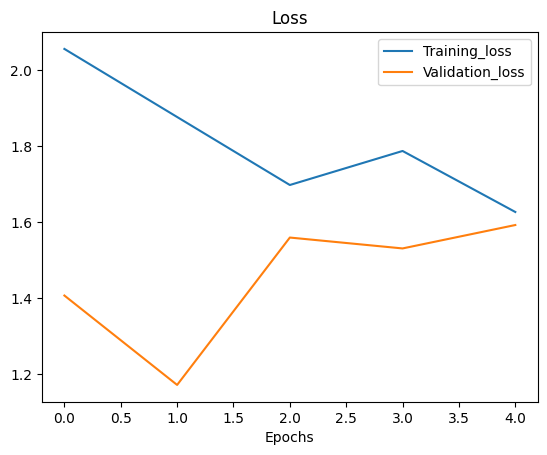

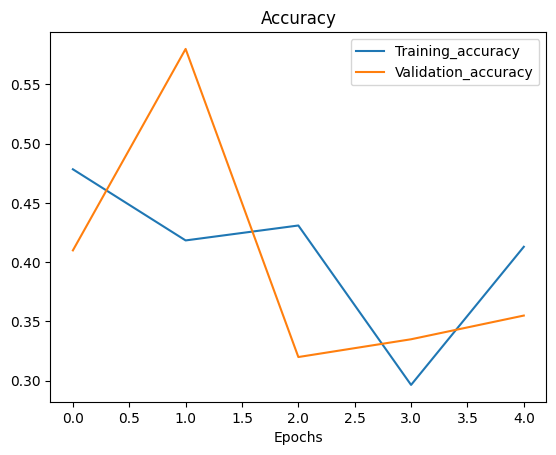

In [ ]:
plot_loss_accuracy(history_strat_1)


###Model 2 stratified

In [ ]:
tf.random.set_seed(42)

model_2_strat = Sequential([
    Input(shape=(224, 224, 3)),

    Conv2D(32, 3, activation="relu",padding="same"),
    MaxPooling2D(),

    Conv2D(64, 3, activation="relu",padding="same"),
    MaxPooling2D(),

    Dropout(0.2),

    Conv2D(128, 3, activation="relu",padding="same"),
    MaxPooling2D(),

    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dense(7, activation="softmax")
])

model_2_strat.compile(loss="sparse_categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

history_strat_2 = model_2_strat.fit(train_ds,
                        steps_per_epoch=len(train_data_strat)//BATCH_SIZE, #Changed training data
                        epochs=15,
                        validation_data=test_ds,
                        class_weight=class_weights #Added class weights
                        )


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 206ms/step - accuracy: 0.2332 - loss: 2.5217 - val_accuracy: 0.0250 - val_loss: 1.7952
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 183ms/step - accuracy: 0.2532 - loss: 2.9354 - val_accuracy: 0.1850 - val_loss: 1.8960
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 239ms/step - accuracy: 0.1173 - loss: 2.5449 - val_accuracy: 0.6750 - val_loss: 1.4618
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 238ms/step - accuracy: 0.1072 - loss: 2.7884 - val_accuracy: 0.0250 - val_loss: 1.8380
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 232ms/step - accuracy: 0.0341 - loss: 2.5956 - val_accuracy: 0.0250 - val_loss: 1.9219
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 219ms/step - accuracy: 0.0457 - loss: 2.4663 - val_accuracy: 0.2100 - val_loss: 1.9445
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 231ms/step - accuracy: 0.1677 - loss: 2.3717 - val_accuracy: 0.4900 - val_loss: 1.8024
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 247ms/step - accuracy: 0.3497 - loss: 2

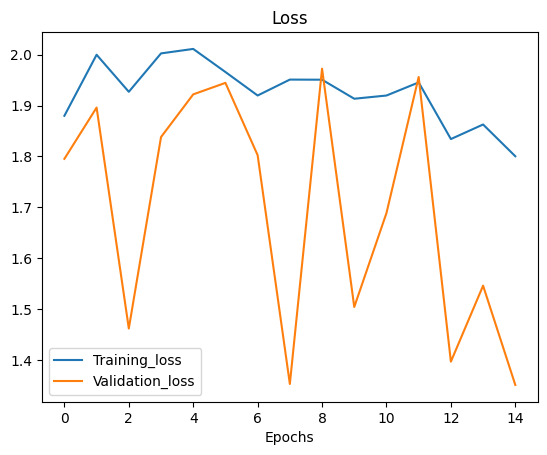

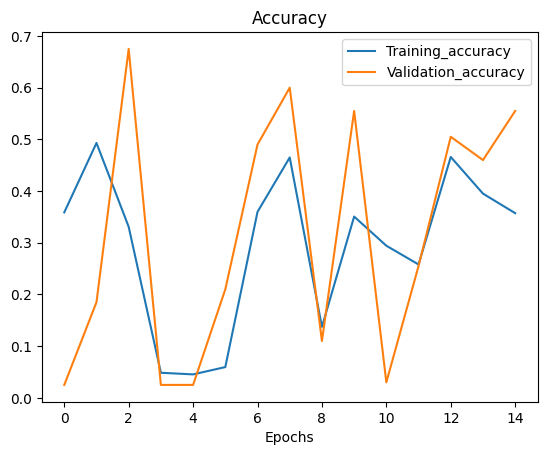

In [ ]:
plot_loss_accuracy(history_strat_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


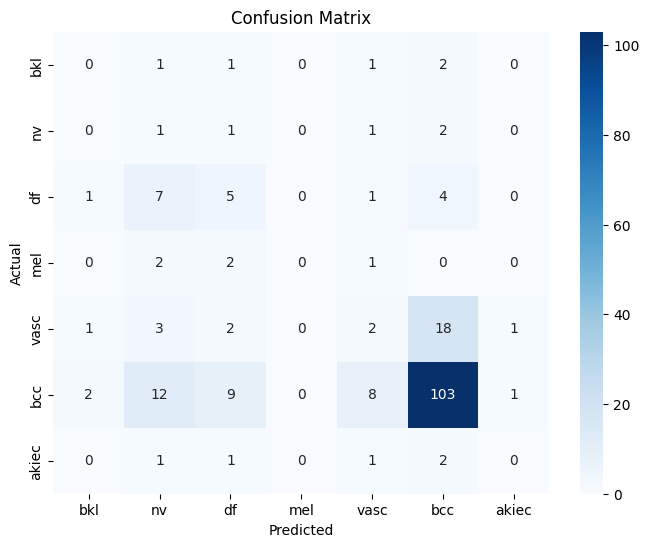


Classification Report:
              precision    recall  f1-score   support

         bkl       0.00      0.00      0.00         5
          nv       0.04      0.20      0.06         5
          df       0.24      0.28      0.26        18
         mel       0.00      0.00      0.00         5
        vasc       0.13      0.07      0.10        27
         bcc       0.79      0.76      0.77       135
       akiec       0.00      0.00      0.00         5

    accuracy                           0.56       200
   macro avg       0.17      0.19      0.17       200
weighted avg       0.57      0.56      0.56       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
plot_confusion_matrix(model_2_strat, test_ds, class_names)

#Transfer Learning

Our custom CNNs (Models 1 & 2) maxed out at ~68% accuracy despite  
stratified data sampling and class-weighting. To break through  
this performance ceiling on our small, complex skin-lesion dataset,  
we’ll now leverage a **pretrained** convolutional base (MobileNetV2).  

By freezing its ImageNet-trained weights and adding a lightweight  
classification head, we combine robust, general vision features  
with a task-specific classifier—dramatically improving accuracy  
with minimal additional training.


##Transfer learning model

In [ ]:
from tensorflow.keras.applications import MobileNetV2

# 1. Loading pretrained base and freezing it
base_model = MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet'
)
base_model.trainable = False

# 2. Adding a classification head
model_transfer = Sequential([
    base_model,
    GlobalAveragePooling2D(),      # collapse each feature map
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax') # 7 skin‐disease classes
])

# 3. Compile
model_transfer.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_transfer = model_transfer.fit(train_ds,
                        steps_per_epoch=len(train_data_strat)//BATCH_SIZE,
                        epochs=15,
                        validation_data=test_ds,
                        class_weight=class_weights
                        )
val_loss, val_acc = model_transfer.evaluate(test_ds)
print(f"Validation loss: {val_loss:.4f}, accuracy: {val_acc:.4f}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 288ms/step - accuracy: 0.1864 - loss: 3.2020 - val_accuracy: 0.4100 - val_loss: 1.6546
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 191ms/step - accuracy: 0.1967 - loss: 2.7927 - val_accuracy: 0.4800 - val_loss: 1.5492
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 207ms/step - accuracy: 0.2487 - loss: 2.4448 - val_accuracy: 0.5600 - val_loss: 1.4358
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 235ms/step - accuracy: 0.3293 - loss: 2.1757 - val_accuracy: 0.6000 - val_loss: 1.3119
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 246ms/step - accuracy: 0.3495 - loss: 2.0377 - val_accuracy: 0.6150 - val_loss: 1.2346
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 207ms/step - accuracy: 0.3674 - loss: 1.9066 - val_accuracy: 0.6250 - val_loss: 1.2014
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 235ms/step - accuracy: 0.4110 - loss: 1.8107 - val_accuracy: 0.6050 - val_loss: 1.1908
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━

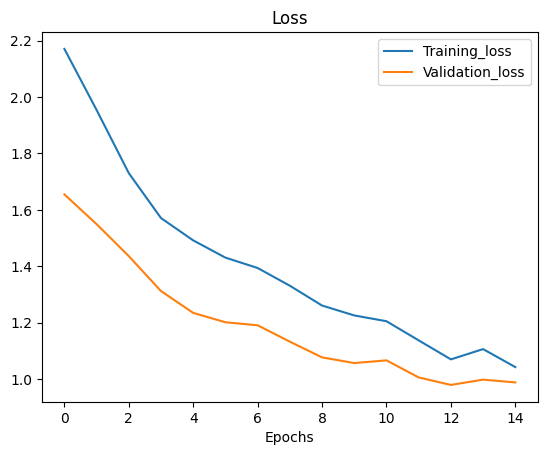

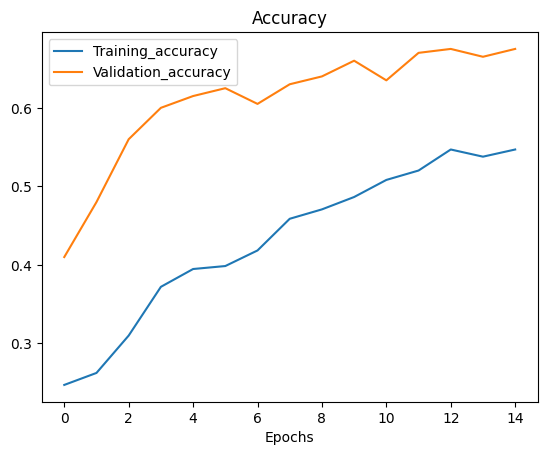

In [ ]:
plot_loss_accuracy(history_transfer)

#Finetuning

###Finetuning model

This is a good improvement compared to before as the model seems to be learning now so we will try a few things:
1. **Unfreeze the Top Layers of the Base Model**  
   - The lower layers of MobileNetV2 capture very general features (edges, textures) that transfer universally. The higher layers learn more task-specific patterns. By unfreezing the last ~15–20 layers, we allow those deeper filters to adapt to subtle skin-lesion characteristics, improving specialization without disrupting the robust foundation.

2. **Train for More Epochs with Early Stopping**  
   - Our initial 15-epoch run showed a consistent downward trend in validation loss and upward trend in accuracy. Extending training to ~30 epochs gives the model more time to refine its weights. We’ll pair this with an `EarlyStopping` callback (patience=5) to automatically restore the best weights once performance plateaus, preventing overfitting.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import clone_model
from tensorflow.keras.optimizers import Adam

# 1. Clone the transfer-learning model
model_transfer_finetune = clone_model(model_transfer)
model_transfer_finetune.set_weights(model_transfer.get_weights())

# 2. Unfreeze the last 20 layers of the base MobileNetV2 within the cloned model
for layer in model_transfer_finetune.layers[0].layers[-20:]:
    layer.trainable = True

# 3. Re-compile
model_transfer_finetune.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
#4. Fit with more epochs

history_transfer_finetune = model_transfer_finetune.fit(train_ds,
                                                        validation_data=test_ds,
                                                        epochs=30,
                                                        steps_per_epoch=len(train_data_strat)//BATCH_SIZE,
                                                        class_weight=class_weights)


val_loss_ft, val_acc_ft = model_transfer_finetune.evaluate(test_ds)
print(f"Fine‐tuned model validation loss: {val_loss_ft:.4f}, accuracy: {val_acc_ft:.4f}")

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 48s 280ms/step - accuracy: 0.3346 - loss: 2.2769 - val_accuracy: 0.6750 - val_loss: 0.9305
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 163ms/step - accuracy: 0.3643 - loss: 1.7784 - val_accuracy: 0.6800 - val_loss: 0.9456
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 235ms/step - accuracy: 0.4311 - loss: 1.4765 - val_accuracy: 0.6850 - val_loss: 0.8661
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 228ms/step - accuracy: 0.4969 - loss: 1.2044 - val_accuracy: 0.6850 - val_loss: 0.9002
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 227ms/step - accuracy: 0.5643 - loss: 0.9469 - val_accuracy: 0.6650 - val_loss: 0.9278
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 232ms/step - accuracy: 0.6132 - loss: 0.7631 - val_accuracy: 0.6900 - val_loss: 0.9086
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 218ms/step - accuracy: 0.6237 - loss: 0.6719 - val_accuracy: 0.7100 - val_loss: 0.8467
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 232ms/step - accuracy: 0.6758 - loss: 0

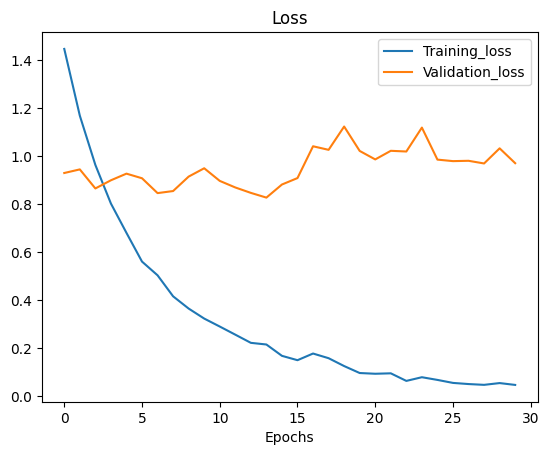

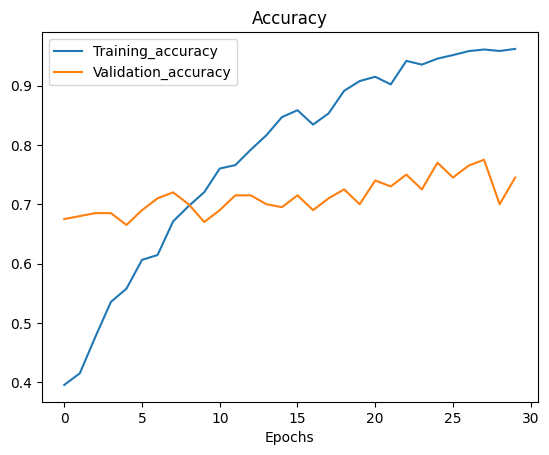

In [ ]:
plot_loss_accuracy(history_transfer_finetune)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


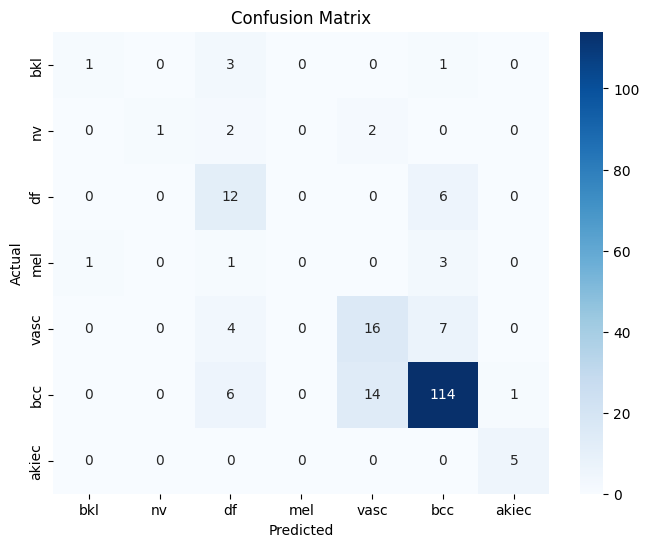


Classification Report:
              precision    recall  f1-score   support

         bkl       0.50      0.20      0.29         5
          nv       1.00      0.20      0.33         5
          df       0.43      0.67      0.52        18
         mel       0.00      0.00      0.00         5
        vasc       0.50      0.59      0.54        27
         bcc       0.87      0.84      0.86       135
       akiec       0.83      1.00      0.91         5

    accuracy                           0.74       200
   macro avg       0.59      0.50      0.49       200
weighted avg       0.75      0.74      0.74       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
plot_confusion_matrix(model_transfer_finetune, test_ds, class_names)

###Changing the data

The model seems to be overfitting on the training data so we will use all the data to train and test the model

In [ ]:
from sklearn.model_selection import train_test_split

# 1) Stratified 80/20 split on your full DataFrame `df`
train_data, test_data = train_test_split(
    df,
    test_size=0.20,
    stratify=df['label_encoded'],
    random_state=42
)

# 2) Verify class balance
print("Train distribution:\n", train_data['label_encoded'].value_counts())
print("Test  distribution:\n", test_data['label_encoded'].value_counts())

# 3) Rebuild train_ds
train_paths  = train_data['image_path'].values
train_labels = train_data['label_encoded'].values

train_ds = (
    tf.data.Dataset
      .from_tensor_slices((train_paths, train_labels))
      .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
      .shuffle(buffer_size=1000)
      .batch(BATCH_SIZE)
      .repeat()
      .prefetch(AUTOTUNE)
)

# 4) Rebuild test_ds
test_paths  = test_data['image_path'].values
test_labels = test_data['label_encoded'].values

test_ds = (
    tf.data.Dataset
      .from_tensor_slices((test_paths, test_labels))
      .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
      .batch(BATCH_SIZE)
      .prefetch(AUTOTUNE)
)

# 5) Compute steps_per_epoch
steps_per_epoch = len(train_data) // BATCH_SIZE
print(f"New steps_per_epoch: {steps_per_epoch}")


Train distribution:
 label_encoded
5    5364
4     890
2     879
1     411
0     262
6     114
3      92
Name: count, dtype: int64
Test  distribution:
 label_encoded
5    1341
4     223
2     220
1     103
0      65
6      28
3      23
Name: count, dtype: int64
New steps_per_epoch: 250


Make class weights again

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Calculate balanced class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights_array))

print("Class weights:", class_weights)


Class weights: {0: np.float64(4.368593238822246), 1: np.float64(2.7848453249913105), 2: np.float64(1.3021290427433772), 3: np.float64(12.440993788819876), 4: np.float64(1.2860353130016051), 5: np.float64(0.21338020666879728), 6: np.float64(10.040100250626567)}


###Finetuning model 2

Make the new model for the full data

In [ ]:
# 1. Clone the transfer-learning model
model_transfer_finetune_2 = clone_model(model_transfer)
model_transfer_finetune_2.set_weights(model_transfer.get_weights())

# 2. Unfreeze the last 20 layers of the base MobileNetV2 within the cloned model
for layer in model_transfer_finetune_2.layers[0].layers[-20:]:
    layer.trainable = True

# 3. Re-compile
model_transfer_finetune_2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
#4. Fit with more epochs

history_transfer_finetune_2 = model_transfer_finetune_2.fit(train_ds,
                                                        validation_data=test_ds,
                                                        epochs=30,
                                                        steps_per_epoch=steps_per_epoch,
                                                        class_weight=class_weights)

val_loss_ft2, val_acc_ft2 = model_transfer_finetune_2.evaluate(test_ds)
print(f"Fine‐tuned 2 loss: {val_loss_ft2:.4f}, acc: {val_acc_ft2:.4f}")

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 121s 392ms/step - accuracy: 0.4418 - loss: 1.4586 - val_accuracy: 0.6835 - val_loss: 0.8790
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 293ms/step - accuracy: 0.5689 - loss: 1.0181 - val_accuracy: 0.6211 - val_loss: 1.0306
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 70s 281ms/step - accuracy: 0.6033 - loss: 0.8394 - val_accuracy: 0.7169 - val_loss: 0.7712
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 92s 367ms/step - accuracy: 0.7012 - loss: 0.6139 - val_accuracy: 0.7474 - val_loss: 0.7263
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 72s 287ms/step - accuracy: 0.7360 - loss: 0.4696 - val_accuracy: 0.7214 - val_loss: 0.7778
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 71s 284ms/step - accuracy: 0.7626 - loss: 0.4034 - val_accuracy: 0.7838 - val_loss: 0.6499
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 319ms/step - accuracy: 0.7904 - loss: 0.3199 - val_accuracy: 0.7469 - val_loss: 0.7455
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 76s 306ms/step - accuracy: 0.8207 - loss: 

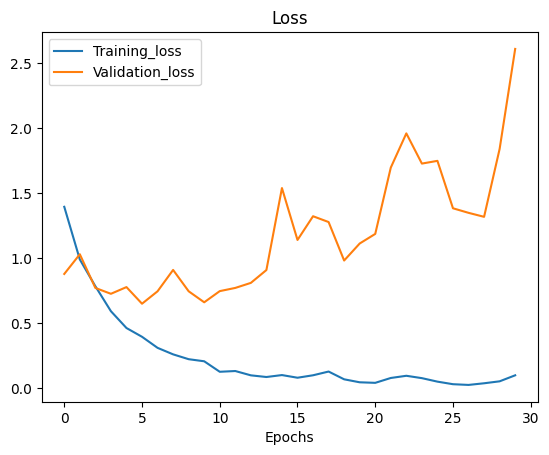

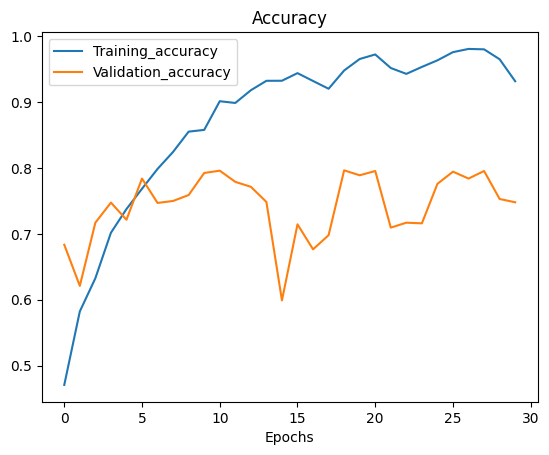

In [ ]:
plot_loss_accuracy(history_transfer_finetune_2)

#Final comparisons

In [ ]:
import pandas as pd

model_names = [
    'Model 1 (simple CNN)',
    'Model 2 (deeper CNN)',
    'Model 1 Stratified',
    'Model 2 Stratified',
    'Transfer Learning model',
    'Transfer Fine-tuned model',
    'Transfer Fine-tuned model 2'
]

val_accs = [
    max(history_1.history['val_accuracy']),            # simple CNN
    max(history_2.history['val_accuracy']),            # deeper CNN
    max(history_strat_1.history['val_accuracy']),      # Model 1 Stratified
    max(history_strat_2.history['val_accuracy']),      # Model 2 Stratified
    max(history_transfer.history['val_accuracy']),     # Transfer Learning
    max(history_transfer_finetune.history['val_accuracy']),  # Transfer Fine-tuned
    max(history_transfer_finetune_2.history['val_accuracy'])  # Transfer Fine-tuned 2
]

df_comparison = pd.DataFrame({
    'Model': model_names,
    'Best Validation Accuracy': [f"{acc*100:.2f}%" for acc in val_accs]
})

print(df_comparison)




                         Model Best Validation Accuracy
0         Model 1 (simple CNN)                   68.00%
1         Model 2 (deeper CNN)                   67.50%
2           Model 1 Stratified                   58.00%
3           Model 2 Stratified                   67.50%
4      Transfer Learning model                   67.50%
5    Transfer Fine-tuned model                   77.50%
6  Transfer Fine-tuned model 2                   79.63%


# Conclusion

We’ve taken this skin‐lesion classification project from a simple CNN (68% accuracy through only guessing) through data-imbalance fixes, stratification, class-weighting, and transfer learning—with fine-tuning pushing validation accuracy to ~80%.  

**Key Learnings:**
- Real-world data is messy and imbalanced; stratified sampling and class weights are essential first steps.  
- Custom CNNs can reach a performance ceiling quickly on small, complex datasets.  
- Transfer learning with a pretrained backbone unlocks dramatically better feature extraction.  
- Fine-tuning deeper layers and regularizing the head helps, but gains taper without more data.  

**Limitations:**
- **Dataset size:** Even with careful sampling, each class had only a few hundred examples.  
- **Intrinsic difficulty:** Seven visually similar conditions are a tough fine-grained task.  
- **Validation noise:** Small hold-out sets lead to natural accuracy fluctuations.

Pushing beyond ~75% would require substantially more images or advanced techniques (ensembles, MixUp/CutMix, pseudo-labeling). For a learning project, this end-to-end pipeline from raw data to a fine-tuned model taught me a great deal about practical machine learning techniques.

---

Thank you for following along! Feel free to explore further improvements, or copy this workflow for your next dataset and problem domain.
